In [15]:
library(glmnet)
library(dplyr)
library(tidyverse)
library(caret)

Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift




**Cleaning data and dropping unnecessary columns**

In [36]:
train <- read.csv("train.csv") %>%
    mutate(price = substr(price, 2, nchar(price)),
          host_response_rate = substr(host_response_rate, 1, nchar(host_response_rate) - 1),
          host_acceptance_rate = substr(host_acceptance_rate, 1, nchar(host_acceptance_rate) - 1),
          price = as.numeric(price),
          host_response_rate = as.numeric(host_response_rate),
          host_acceptance_rate = as.numeric(host_acceptance_rate)) %>%
    select(-X, -id, -name, -neighborhood_overview, -host_id, -host_name, 
           -neighbourhood, -latitude, -longitude, -bathrooms, -bedrooms, -amenities) %>%
    mutate(property_type = if_else(property_type %in% c("Camper/RV", "Entire home", 
                                                        "Entire villa", "Private room in bungalow", "Private room in condo",
                                                        "Room in hotel"),
                                  property_type,
                                  "Other"),
          neighbourhood_cleansed = if_else(neighbourhood_cleansed %in% c("Downtown Eastside", "Dunbar Southlands",
                                                                         "Grandview-Woodland", "Killarney", "Kitsilano", 
                                                                         "Marpole", "Mount Pleasant", "Oakridge", 
                                                                         "West End", "West Point Grey"),
                                          neighbourhood_cleansed,
                                          "Other"),
          room_type = if_else(room_type %in% c("Private room", "Shared room"),
                             room_type,
                             "Other")
          #  ,
          # neighbourhood = if_else(grepl("vancouver", tolower(neighbourhood), fixed = TRUE),
          #                        "Vancouver",
          #                        "Other")
          )
dmy <- dummyVars(" ~ .", data = train)
train <- data.frame(predict(dmy, newdata = train))

test <- read.csv("test.csv") %>%
    mutate(price = substr(price, 2, nchar(price)),
          host_response_rate = substr(host_response_rate, 1, nchar(host_response_rate) - 1),
          host_acceptance_rate = substr(host_acceptance_rate, 1, nchar(host_acceptance_rate) - 1),
          price = as.numeric(price),
          host_response_rate = as.numeric(host_response_rate),
          host_acceptance_rate = as.numeric(host_acceptance_rate)) %>%
    select(-id, -name, -neighborhood_overview, -host_id, -host_name, 
           -neighbourhood, -latitude, -longitude, -bathrooms, -bedrooms, -amenities) %>%
    mutate(property_type = if_else(property_type %in% c("Camper/RV", "Entire home", 
                                                        "Entire villa", "Private room in bungalow", "Private room in condo",
                                                        "Room in hotel"),
                                  property_type,
                                  "Other"),
          neighbourhood_cleansed = if_else(neighbourhood_cleansed %in% c("Downtown Eastside", "Dunbar Southlands",
                                                                         "Grandview-Woodland", "Killarney", "Kitsilano", 
                                                                         "Marpole", "Mount Pleasant", "Oakridge", 
                                                                         "West End", "West Point Grey"),
                                          neighbourhood_cleansed,
                                          "Other"),
          room_type = if_else(room_type %in% c("Private room", "Shared room"),
                             room_type,
                             "Other")
          #  ,
          # neighbourhood = if_else(grepl("vancouver", tolower(neighbourhood), fixed = TRUE),
          #                        "Vancouver",
          #                        "Other")
          )
dmy <- dummyVars(" ~ .", data = test)
test <- data.frame(predict(dmy, newdata = test))

Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `price = as.numeric(price)`.
Caused by warning:
! NAs introduced by coercion”
Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `price = as.numeric(price)`.
Caused by warning:
! NAs introduced by coercion”


**Fitting a lasso regression model using cross validation to select the best regularization parameter**|

[1] 5.777081

58 x 1 sparse Matrix of class "dgCMatrix"
                                                    s0
(Intercept)                              -1.242773e+03
host_response_time                        2.107106e+01
host_response_timea.few.days.or.more     -8.443499e+01
host_response_timewithin.a.day            .           
host_response_timewithin.a.few.hours      2.093378e+01
host_response_timewithin.an.hour         -1.136247e+00
host_response_rate                        3.718878e-01
host_acceptance_rate                      2.538902e-01
host_is_superhost                         .           
host_is_superhostf                        .           
host_is_superhostt                        .           
host_listings_count                       .           
host_total_listings_count                 3.151315e-02
neighbourhood_cleansedDowntown.Eastside   6.577431e+01
neighbourhood_cleansedDunbar.Southlands  -1.280339e+02
neighbourhood_cleansedGrandview.Woodland  1.424805e+02
neighbourhood_cleansedK

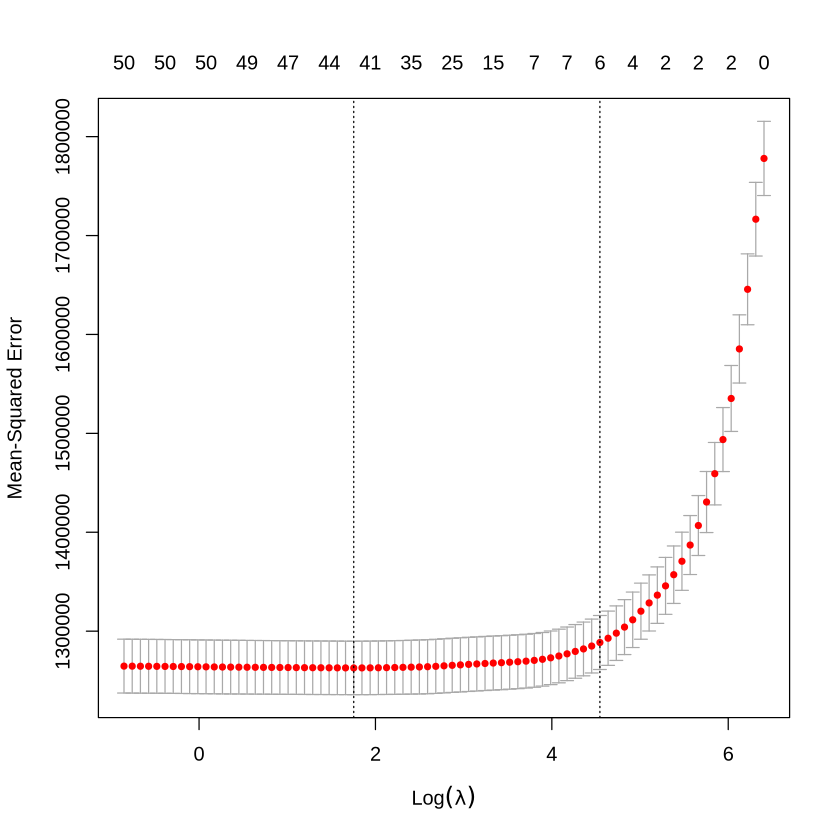

In [37]:
y <- train$monthly_revenue
X <- makeX(train %>% select(-monthly_revenue),
          na.impute = TRUE)

cv_model <- cv.glmnet(X, y, alpha = 1)

best_lambda <- cv_model$lambda.min
best_lambda

plot(cv_model) 

best_model <- glmnet(X, y, alpha = 1, lambda = best_lambda)
coef(best_model)

**Performace metrics**

In [57]:
pred_y <- predict(best_model, s = best_lambda, newx = X)

sst <- sum((y - mean(y))^2)
sse <- sum((pred_y - y)^2)
rsq <- 1 - sse/sst

cat("Sum of squares error:", sse, "\n")
cat("R-Squared:", rsq)

Sum of squares error: 6658037739 
R-Squared: 0.3013145

**Making predictions and saving to csv**

In [35]:
x_test <- makeX(test,
          na.impute = TRUE)

pred_y_test <- predict(best_model, s = best_lambda, newx = x_test)

latest <- data.frame(read.csv("test.csv", colClasses = c("id" = "character"))$id, pred_y_test)
colnames(latest) <- c("id", "predictions")
head(latest)

write.csv(latest, "predictions.csv", row.names = FALSE)

,id,predictions
,<chr>,<dbl>
1,4465400,3787.466
2,608629349064811166,1370.057
3,981894508939312892,1799.171
4,52014961,1719.834
5,836285112356489303,1262.120
6,729730483477613494,1846.086


**Principle Component Analysis**

In [49]:
pca_data <- read.csv("train.csv")

colnames(pca_data) <- make.names(colnames(pca_data))
pca_data <- subset(pca_data, select = -c(X, id, host_id, host_name, neighbourhood, 
                                             latitude, longitude, bathrooms, bedrooms, amenities))

pca_data$price <- as.numeric(gsub("[$,]", "", pca_data$price))

In [44]:
pca_data_numeric <- pca_data %>%
  select_if(is.numeric) %>%
  mutate_all(~ ifelse(is.na(.), median(., na.rm = TRUE), .))

pca_data_scaled <- scale(pca_data_numeric)

pca_result <- prcomp(pca_data_scaled, center = TRUE, scale. = TRUE)

summary(pca_result)

Importance of components:
                          PC1    PC2    PC3     PC4     PC5     PC6     PC7
Standard deviation     2.2479 1.8860 1.6793 1.51215 1.47930 1.32334 1.15567
Proportion of Variance 0.2021 0.1423 0.1128 0.09146 0.08753 0.07005 0.05342
Cumulative Proportion  0.2021 0.3444 0.4572 0.54866 0.63619 0.70624 0.75967
                           PC8     PC9    PC10    PC11    PC12    PC13    PC14
Standard deviation     0.97563 0.81865 0.81438 0.76040 0.72375 0.68455 0.65688
Proportion of Variance 0.03807 0.02681 0.02653 0.02313 0.02095 0.01874 0.01726
Cumulative Proportion  0.79774 0.82455 0.85108 0.87420 0.89516 0.91390 0.93116
                          PC15    PC16    PC17    PC18    PC19    PC20    PC21
Standard deviation     0.58377 0.55324 0.50139 0.46217 0.37291 0.37156 0.34229
Proportion of Variance 0.01363 0.01224 0.01006 0.00854 0.00556 0.00552 0.00469
Cumulative Proportion  0.94479 0.95703 0.96709 0.97563 0.98120 0.98672 0.99141
                          PC22    PC23

In [48]:
loadings <- pca_result$rotation

loadings_pc1_pc2 <- loadings[, 1:7]
top_pc1 <- loadings_pc1_pc2[order(abs(loadings_pc1_pc2[, 1]), decreasing = TRUE), 1]
top_pc2 <- loadings_pc1_pc2[order(abs(loadings_pc1_pc2[, 2]), decreasing = TRUE), 2]

print("Top variables contributing to PC1:")
print(top_pc1)

print("Top variables contributing to PC2:")
print(top_pc2)

[1] "Top variables contributing to PC1:"
          review_scores_rating         review_scores_accuracy 
                  -0.405411292                   -0.389654941 
           review_scores_value    review_scores_communication 
                  -0.387658085                   -0.369575689 
     review_scores_cleanliness          review_scores_checkin 
                  -0.362047826                   -0.332674046 
        review_scores_location                availability_30 
                  -0.259761815                    0.106115378 
               availability_60                availability_90 
                   0.103611020                    0.101367805 
              availability_365              reviews_per_month 
                   0.088803316                   -0.085557021 
         number_of_reviews_ltm                monthly_revenue 
                  -0.082296717                   -0.081814473 
     host_total_listings_count              number_of_reviews 
              